# Nhập và xử lý số liệu

In [3]:
import pandas as pd
df = pd.read_csv('Downloads/FPT.csv')
df=df[['Date/Time','Close']]
df['Date/Time']=pd.to_datetime(df['Date/Time'])
df=df.dropna()
df.drop_duplicates(inplace=True)

# Chọn giá đóng cửa ghi nhận trong 2 ngày 09/07/2019 và 10/07/2019

In [5]:
df = df[(df['Date/Time']>'2019-07-09')]
df.reset_index(drop=True)

,Date/Time,Close
0,2019-07-09 09:15:00,38.78
1,2019-07-09 09:16:00,38.69
2,2019-07-09 09:18:00,38.69
3,2019-07-09 09:19:00,38.69
4,2019-07-09 09:20:00,38.69
...,...,...
364,2019-07-10 13:40:00,39.57
365,2019-07-10 13:42:00,39.57
366,2019-07-10 13:43:00,39.57
367,2019-07-10 13:44:00,39.53


In [6]:
del df['Date/Time']

# Chia giá đóng cửa ra làm 2 phần: train (dùng để dựng mô hình và dự báo) và test (dùng để so sánh với giá trị dự báo)

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)

# Kiểm định tính dừng cho chuỗi train bằng kiểm định Dickey-Fuller

In [10]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train)
print(f'p-value: {adf_test[1]}')

p-value: 0.9363077031881922


# Với p-value > 0.05 cho thấy chuỗi train chưa dừng, cần lấy sai phân 
# Dùng lệnh ndiffs để tìm số lần lấy sai phân đến khi chuỗi dừng

In [12]:
from pmdarima.arima.utils import ndiffs
ndiffs(train, test = "adf")

1

<Axes: >

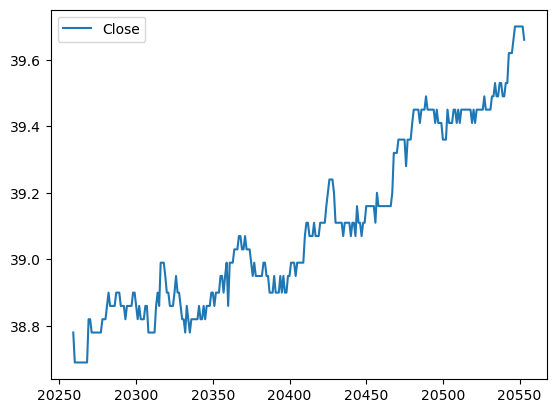

In [13]:
train.plot()

# Vẽ biểu đồ ACF và PACF cho chuỗi train sau khi lấy sai phân 1 lần để tìm giá trị p, q của mô hình ARIMA

In [14]:
diff=train.diff().dropna()

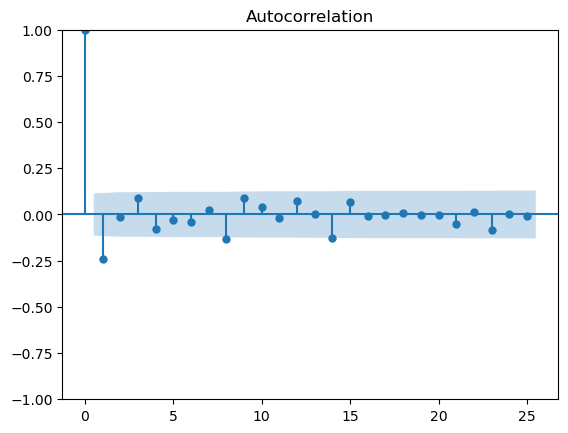

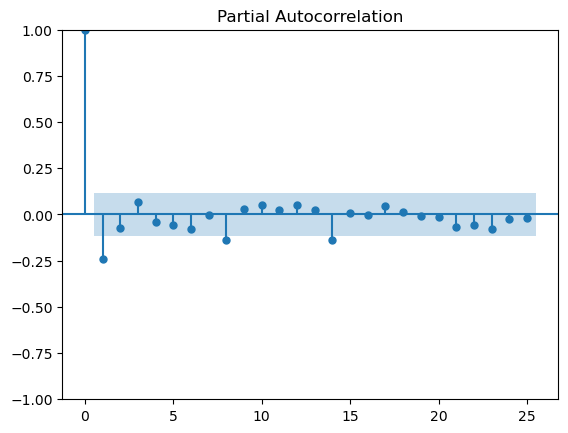

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf= plot_acf(diff)
pacf= plot_pacf(diff)

# Dựa vào 2 biểu đồ trên, lựa chọn p = 14 và q = 14 => mô hình ARIMA(14,1,14)

In [16]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(14,1,14))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\MTHH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\MTHH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\MTHH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\MTHH\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\MTHH\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters fo

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  295
Model:               ARIMA(14, 1, 14)   Log Likelihood                 584.163
Date:                Wed, 17 Jul 2024   AIC                          -1110.325
Time:                        16:40:13   BIC                          -1003.501
Sample:                             0   HQIC                         -1067.545
                                - 295                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2226      2.351     -0.095      0.925      -4.830       4.385
ar.L2         -0.0553      2.640     -0.021      0.983      -5.229       5.118
ar.L3          0.0373      2.060      0.018      0.9

# Dự báo giá đóng cửa từ mô hình

In [17]:
forecast_test = model_fit.forecast(len(test))
forecast_test

C:\Users\MTHH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\MTHH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


295    39.673950
296    39.673305
297    39.677308
298    39.676643
299    39.691073
         ...    
364    39.689178
365    39.689179
366    39.689184
367    39.689178
368    39.689180
Name: predicted_mean, Length: 74, dtype: float64

In [18]:
df['forecast'] = [None]*len(train) + list(forecast_test)

<Axes: >

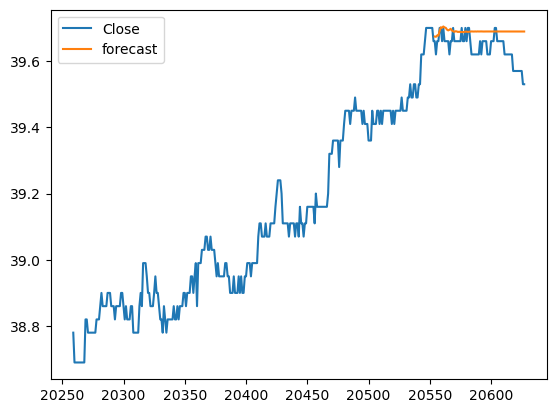

In [19]:
df.plot()